In [1]:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning

In [2]:
# read data
file_path = "./hotel_bookings.csv"
full_data = pd.read_csv(file_path)
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# stats for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
## replace missing values:
# only 3 columns have missing values: country; deposit_type; company
replace_dict = {"children:": 0.0, "country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(replace_dict)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# drop entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [5]:
# after cleaning, there is 119210 samples
full_data_cln.shape

(119210, 32)

# Cancellation Prediction

In [6]:
cancel_corr = full_data_cln.corr()["is_canceled"]
corr = cancel_corr.abs().sort_values(ascending=False)

In [7]:
ys = corr[1:]
xs = ['lead_time', 'total_of_special_requests', 'required_car_parking_spaces',\
     'booking_changes', 'previous_cancellations', 'is_repeated_guest', \
     'company', 'adults', 'previous_bookings_not_canceled', 'days_in_waiting_list',\
     'agent', 'adr', 'babies', 'stays_in_week_nights', 'arrival_date_year', \
     'arrival_date_week_number', 'arrival_date_day_of_month', 'children', 'stays_in_weekend_nights']

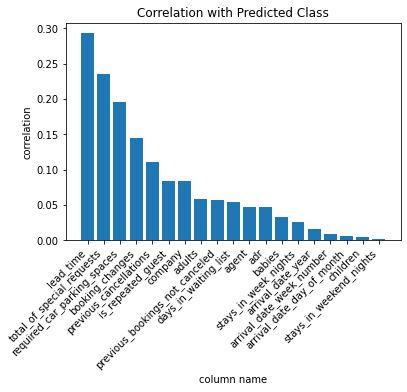

In [8]:
plt.bar(xs, ys)
plt.xticks(rotation=45, ha='right')
plt.xlabel("column name")
plt.ylabel("correlation")
plt.title("Correlation with Predicted Class")
plt.show()

In [9]:
cancel_counts = full_data_cln['is_canceled'].value_counts()
cancel_counts

0    75011
1    44199
Name: is_canceled, dtype: int64

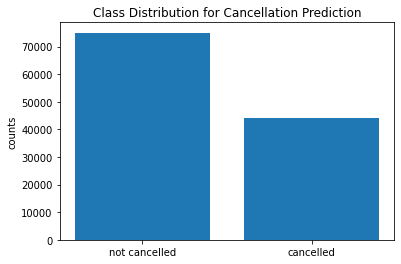

0.629234124653972

In [10]:
# naive accuracy
plt.bar(["not cancelled", "cancelled"], cancel_counts)
plt.ylabel("counts")
plt.title("Class Distribution for Cancellation Prediction")
plt.show()

print("naive baseline: %.3f" % (cancel_counts[0] / (cancel_counts[0] + cancel_counts[1])))

## feature selection

In [11]:
## choose the 10 most useful features based on correlation

# all features are numerical
full_feature_list = ["lead_time", "total_of_special_requests", \
                    "required_car_parking_spaces", "booking_changes",\
                    "previous_cancellations", "is_repeated_guest",\
                    "agent", "adults", "previous_bookings_not_canceled",\
                    "days_in_waiting_list"]

X = full_data_cln.drop(["is_canceled"], axis=1)[full_feature_list]
y = full_data_cln["is_canceled"]

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

num_folds = 5 # 5 fold cross validation = 80% train, 20% validation

In [13]:
def train(model, model_name, X, y, num_folds):    
    clf = make_pipeline(StandardScaler(), model)
    scores = cross_val_score(clf, X, y, cv=num_folds, scoring='accuracy', n_jobs=-1)
    print("{} performance: {:.4f} +- {:.4f}".format(model_name, np.mean(scores), np.std(scores)))

## model - Gaussian Naive Bayes

In [14]:
# init model - Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model_name = "Gaussian Naive Bayes"

# train
train(model, model_name, X, y, num_folds)

Gaussian Naive Bayes performance: 0.46 +- 0.06


## model - Logistic Regression

In [15]:
# init model - Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model_name = "Logistic Regression"

# train
train(model, model_name, X, y, num_folds)

Logistic Regression performance: 0.69 +- 0.07


## model - XGBoost

In [16]:
# init model - XGBoost
from xgboost import XGBClassifier
model = XGBClassifier()
model_name = "XGBoost"

# train
train(model, model_name, X, y, num_folds)

XGBoost performance: 0.71 +- 0.05


## model - neural networks

In [ ]:
# init model - simple neural network
import torch
from torch import nn
import torch.nn.functional as F

## network definition
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super(SimpleNet, self).__init__()
        
        self.layer_1 = nn.Linear(input_dim, hid_dim) 
        self.layer_2 = nn.Linear(hid_dim, hid_dim)
        self.layer_out = nn.Linear(hid_dim, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(hid_dim)
        self.batchnorm2 = nn.BatchNorm1d(hid_dim)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        x = torch.sigmoid(x)
        return x

In [67]:
# evaluation code

from sklearn.metrics import confusion_matrix, classification_report
def evaluate(model, dataloader, loss_func = nn.BCELoss()):
    correct = 0
    total = 0
    y_pred_list = []
    y_gt_list = []
    
    criterion = loss_func
    
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            if use_gpu:
                inputs = inputs.to("cuda:0")
                labels = labels.to("cuda:0")
            labels = labels.unsqueeze(-1)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            predicted = torch.round(outputs)
            # stats
            total += labels.size(0)
            correct += int((predicted == labels).sum().item())
            running_loss += float(loss.item())
    
    print('Accuracy: %d %%\tLoss: %.3f' % (100.0 * correct / total, running_loss/len(dataloader)))
    return 1.0 * correct / total

In [68]:
# train code
from sklearn.model_selection import KFold

def train_ann(X, y, num_folds, lr = 0.01, hid_dim = 64, loss_func = nn.BCELoss(), run_cv=False):
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    best_eval_acc_list = []
    
    # grid search 
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        # Print
        print(f'FOLD {fold}')
        
        # init data
        best_eval_acc = -1
        train_data = []
        test_data = []
        X_train = X.to_numpy()[train_ids]
        y_train = y.to_numpy()[train_ids]
        X_test = X.to_numpy()[test_ids]
        y_test = y.to_numpy()[test_ids]
        # normalize data
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        X_test_transformed = scaler.transform(X_test)

        for i in range(len(X_train)):
            train_data.append([X_train_transformed[i], y_train[i]])
        for i in range(len(X_test)):
            test_data.append([X_test_transformed[i], y_test[i]])

        trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=512)
        testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=512)

        # init model
        simple_ann = SimpleNet(X.shape[1], hid_dim)
        if use_gpu:
            simple_ann.to("cuda:0")

        # init training
        optimizer = torch.optim.SGD(simple_ann.parameters(), lr=lr, momentum=0.9)
        criterion = loss_func

        # training
        for epoch in range(num_epoch):  
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.float(), labels.float()
                if use_gpu:
                    inputs = inputs.to("cuda:0")
                    labels = labels.to("cuda:0")
                labels = labels.unsqueeze(-1)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = simple_ann(inputs)
                loss = criterion(outputs, labels)
                
                if i%200 == 199:
                    _, predicted = torch.max(outputs.data, 1)
                    num_correct = (predicted == labels.squeeze()).sum().item()
                    print(loss.item(), num_correct / 512.0)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += float(loss.item())

            if epoch % 10 == 9:
                print('[epoch %d] loss: %.3f' %
                      (epoch + 1, running_loss / len(trainloader)))
        
                simple_ann.eval()
                evaluate(simple_ann, trainloader)
                eval_acc = evaluate(simple_ann, testloader)
                if eval_acc > best_eval_acc:
                    best_eval_acc = eval_acc
                simple_ann.train()
        
        # done with this fold
        best_eval_acc_list.append(best_eval_acc)
        if not run_cv:
            break
    return best_eval_acc_list

### model - neural net - grid search

In [38]:
# parameter list for grid search
lr_list = [0.1, 0.03, 0.01, 0.003, 0.001]
hid_dim_list = [256, 64, 16]
loss_list = [nn.BCELoss(), nn.L1Loss()]

# training parameters
use_gpu = True
num_epoch = 75

results = []
for loss in loss_list:
    for hid_dim in hid_dim_list: 
        for lr in lr_list:
            print(lr, hid_dim, loss)
            best_eval_acc_list = train_ann(X, y, 5, lr, hid_dim, loss, False)
            print("best eval score: %.3f" %(np.max(best_eval_acc)))
            results.append(np.max(best_eval_acc))

0.1 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.475
Accuracy: 76 %	Loss: 0.471
Accuracy: 76 %	Loss: 0.474
[epoch 20] loss: 0.464
Accuracy: 77 %	Loss: 0.459
Accuracy: 77 %	Loss: 0.464
[epoch 30] loss: 0.460
Accuracy: 77 %	Loss: 0.453
Accuracy: 77 %	Loss: 0.456
[epoch 40] loss: 0.453
Accuracy: 77 %	Loss: 0.453
Accuracy: 77 %	Loss: 0.459
[epoch 50] loss: 0.450
Accuracy: 77 %	Loss: 0.445
Accuracy: 77 %	Loss: 0.453
[epoch 60] loss: 0.448
Accuracy: 78 %	Loss: 0.440
Accuracy: 77 %	Loss: 0.447
[epoch 70] loss: 0.445
Accuracy: 78 %	Loss: 0.440
Accuracy: 78 %	Loss: 0.447
best eval score: 0.784
0.03 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.479
Accuracy: 76 %	Loss: 0.475
Accuracy: 76 %	Loss: 0.477
[epoch 20] loss: 0.471
Accuracy: 76 %	Loss: 0.464
Accuracy: 76 %	Loss: 0.468
[epoch 30] loss: 0.464
Accuracy: 76 %	Loss: 0.460
Accuracy: 76 %	Loss: 0.463
[epoch 40] loss: 0.461
Accuracy: 77 %	Loss: 0.456
Accuracy: 77 %	Loss: 0.460
[epoch 50] loss: 0.458
Accuracy: 77 %	Loss: 0.452
Accuracy: 77 %	Loss: 0.458
[e

In [41]:
np.min(results), np.max(results)

(0.750314570925258, 0.7838268601627381)

In [42]:
results_array = np.array(results).reshape((2,3,5))

array([0.78382686, 0.77992618, 0.7760255 , 0.7684758 , 0.7681822 ])

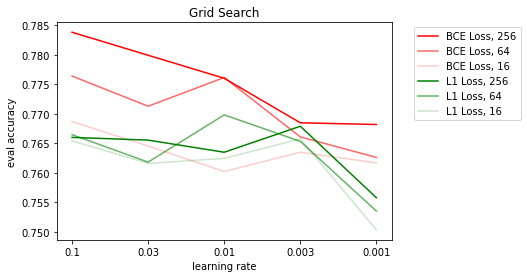

In [60]:
xx = ["0.1", "0.03", "0.01", "0.003", "0.001"]
plt.plot(xx, results_array[0,0], label="BCE Loss, 256", c="r", alpha=1)
plt.plot(xx, results_array[0,1], label="BCE Loss, 64", c="r", alpha=0.6)
plt.plot(xx, results_array[0,2], label="BCE Loss, 16", c="r", alpha=0.2)
plt.plot(xx, results_array[1,0], label="L1 Loss, 256", c="g", alpha=1)
plt.plot(xx, results_array[1,1], label="L1 Loss, 64", c="g", alpha=0.6)
plt.plot(xx, results_array[1,2], label="L1 Loss, 16", c="g", alpha=0.2)
plt.legend(bbox_to_anchor=(1.4, 1))
plt.ylabel("eval accuracy")
plt.xlabel("learning rate")
plt.title("Grid Search")
plt.show()

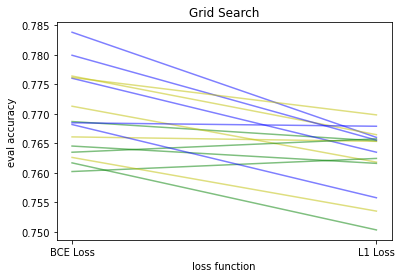

In [58]:
xx = ["BCE Loss", "L1 Loss"]
for i in range(5):
    plt.plot(xx, results_array[:,0,i], c="b", alpha=.5)
    plt.plot(xx, results_array[:,1,i], c="y", alpha=.5)
    plt.plot(xx, results_array[:,2,i], c="g", alpha=.5)

# plt.legend(bbox_to_anchor=(1.4, 1))
plt.ylabel("eval accuracy")
plt.xlabel("loss function")
plt.title("Grid Search")
plt.show()

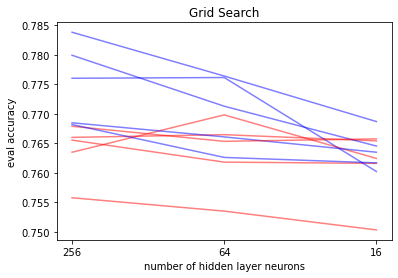

In [61]:
xx = ["256", "64", "16"]
for i in range(5):
    plt.plot(xx, results_array[0,:,i], c="b", alpha=.5)
    plt.plot(xx, results_array[1,:,i], c="r", alpha=.5)

# plt.legend(bbox_to_anchor=(1.4, 1))
plt.ylabel("eval accuracy")
plt.xlabel("number of hidden layer neurons")
plt.title("Grid Search")
plt.show()

### model - neural net - final setup

In [69]:
# train with the best parameters with cross validation
best_eval_acc_list = train_ann(X, y, 5, 0.1, 256, nn.BCELoss(), True)

FOLD 0
[epoch 10] loss: 0.479
Accuracy: 75 %	Loss: 0.478
Accuracy: 75 %	Loss: 0.478
[epoch 20] loss: 0.470
Accuracy: 76 %	Loss: 0.466
Accuracy: 76 %	Loss: 0.462
[epoch 30] loss: 0.462
Accuracy: 76 %	Loss: 0.459
Accuracy: 77 %	Loss: 0.457
[epoch 40] loss: 0.455
Accuracy: 77 %	Loss: 0.450
Accuracy: 77 %	Loss: 0.451
[epoch 50] loss: 0.453
Accuracy: 77 %	Loss: 0.447
Accuracy: 78 %	Loss: 0.447
[epoch 60] loss: 0.449
Accuracy: 78 %	Loss: 0.441
Accuracy: 78 %	Loss: 0.443
[epoch 70] loss: 0.447
Accuracy: 77 %	Loss: 0.444
Accuracy: 77 %	Loss: 0.447
FOLD 1
[epoch 10] loss: 0.479
Accuracy: 76 %	Loss: 0.472
Accuracy: 76 %	Loss: 0.473
[epoch 20] loss: 0.465
Accuracy: 77 %	Loss: 0.459
Accuracy: 77 %	Loss: 0.460
[epoch 30] loss: 0.457
Accuracy: 77 %	Loss: 0.456
Accuracy: 76 %	Loss: 0.459
[epoch 40] loss: 0.454
Accuracy: 77 %	Loss: 0.452
Accuracy: 77 %	Loss: 0.456
[epoch 50] loss: 0.450
Accuracy: 78 %	Loss: 0.444
Accuracy: 78 %	Loss: 0.448
[epoch 60] loss: 0.448
Accuracy: 78 %	Loss: 0.442
Accuracy: 78

In [70]:
best_eval_acc_list

[0.7837849173727036,
 0.7818555490311215,
 0.7827363476218439,
 0.7787937253586108,
 0.7784581830383357]

No handles with labels found to put in legend.


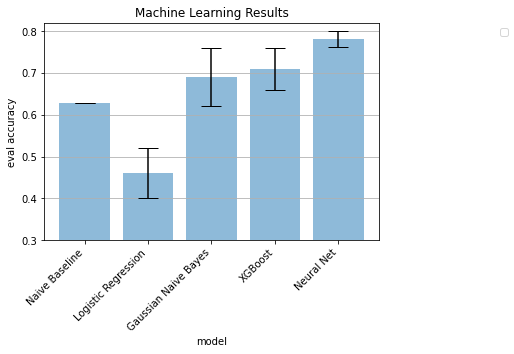

In [83]:
xx = ["Naive Baseline", "Logistic Regression", "Gaussian Naive Bayes", "XGBoost", "Neural Net"]
y = [0.629, 0.46, 0.69, 0.71, 0.781]
error_bar = [0, 0.06, 0.07, 0.05, 0.02]
plt.bar(xx, y, yerr=error_bar, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel("eval accuracy")
plt.xlabel("model")
plt.ylim([0.3,0.82])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.yaxis.grid(True)
plt.title("Machine Learning Results")
plt.show()